In [10]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision
import wandb  # Step 8: Import wandb for experiment tracking
import time
from torch.optim import Adam
from datetime import datetime
import pandas as pd
from tqdm import tqdm
import math
from torchvision.models import resnet50

batch_size = 128
learning_rate = 1e-3
image_size = 64

data_dir = '../data/anime_faces/'

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset and split into train and validation sets
dataset = ImageFolder(data_dir, transform=transform)
val_size = int(len(dataset) * 0.1)  # 10% for validation
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6)

# Step 9: Creating a dataframe to keep track of metrics for each epoch
metrics_df = pd.DataFrame(columns=["epoch", "train_loss", "val_loss", "time"])

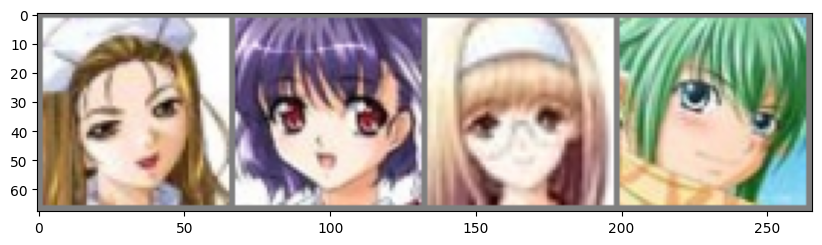

In [11]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # convert from Tensor image

for images, labels in train_dataloader:
    imshow(torchvision.utils.make_grid(images[0:4]))
    break

In [16]:
class GaussianNoise(nn.Module):
    def __init__(self, std=0.1):
        super().__init__()
        self.std = std

    def forward(self, x):
        if self.training:
            return x + torch.randn_like(x) * self.std
        return x

class Generator(nn.Module):
    def __init__(self, z_dim=128, image_channels=3):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 2*2*512),
            nn.ReLU(),
            GaussianNoise(std=0.1),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            GaussianNoise(std=0.1),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            GaussianNoise(std=0.1),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            GaussianNoise(std=0.1),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            GaussianNoise(std=0.1),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self, image_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            GaussianNoise(std=0.1),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            GaussianNoise(std=0.1),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            GaussianNoise(std=0.1),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            GaussianNoise(std=0.1),
            nn.Flatten(),
            nn.Linear(8192, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [17]:
import numpy as np
from scipy.linalg import sqrtm

# Your existing code
z_dim = 256
generator = Generator(z_dim=z_dim).cuda()
discriminator = Discriminator().cuda()

optimizer_G = Adam(generator.parameters(), lr=1e-4)
optimizer_D = Adam(discriminator.parameters(), lr=1e-4)

criterion = nn.BCEWithLogitsLoss()

real_label = 1
fake_label = 0

run = wandb.init(project="gan_training", config={
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "optimizer": "Adam",
    "architecture": "GAN"
})

config = wandb.config
num_epochs = 100

def activation_hook(name):
    def hook(module, input, output):
        wandb.log({name: output.detach().cpu().numpy()})
    return hook

layer_name = 'model.0'
layer = dict(generator.named_modules())[layer_name]
hook = layer.register_forward_hook(activation_hook(layer_name))

def validate(epoch):
    generator.eval()
    #print("Validating...")
    with torch.no_grad():
        fixed_z = torch.randn(9, z_dim, device='cuda')
        fixed_fake_images = generator(fixed_z)
        grid = torchvision.utils.make_grid(fixed_fake_images)
        wandb.log({"generated_images": [wandb.Image(grid, caption="Epoch {}".format(epoch))]})
        # Add FID score calculation here using a validation batch
        real_images_val = next(iter(val_dataloader))[0].cuda()
        z = torch.randn(9, z_dim, device='cuda') # removed 1, 1
        fake_images_val = generator(z)
        #print("Generated images shape: {}".format(fake_images_val.shape))
        #print("Calculating FID score...")
        #fid_score = calculate_fid(real_images_val.cpu().numpy(), fake_images_val.cpu().numpy())
        #wandb.log({"fid_score": fid_score})

for epoch in tqdm(range(num_epochs), total=num_epochs):
    generator.train()
    for batch_idx, (real_images, _) in enumerate(train_dataloader):
        real_images = real_images.cuda()
        batch_size = real_images.size(0)

        # Train the discriminator
        optimizer_D.zero_grad()

        z = torch.randn(batch_size, z_dim, device='cuda')
        fake_images = generator(z)
        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images.detach())

        d_loss = - real_output.mean() + fake_output.mean()
        d_loss.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-0.01, 0.01)

        # Track real vs. fake accuracy
        real_correct = real_output.gt(0.5).sum().item()
        fake_correct = fake_output.lt(0.5).sum().item()
        real_total = real_output.numel()
        fake_total = fake_output.numel()
        wandb.log({"real_accuracy": real_correct / real_total, "fake_accuracy": fake_correct / fake_total})

        # Track model weights
        for name, param in generator.named_parameters():
            if param.data is not None:
                wandb.log({"generator_" + name + "_weight_norm": param.data.norm(2).item()})
        for name, param in discriminator.named_parameters():
            if param.data is not None:
                wandb.log({"discriminator_" + name + "_weight_norm": param.data.norm(2).item()})

        # Train the generator
        optimizer_G.zero_grad()

        fake_output = discriminator(fake_images)
        g_loss = - fake_output.mean()
        g_loss.backward()
        optimizer_G.step()

        # Log gradients
        for name, param in generator.named_parameters():
            if param.grad is not None:
                wandb.log({"generator_" + name + "_grad_norm": param.grad.data.norm(2).item()})
        for name, param in discriminator.named_parameters():
            if param.grad is not None:
                wandb.log({"discriminator_" + name + "_grad_norm": param.grad.data.norm(2).item()})

        """if batch_idx % 50 == 0:
            print(f'Epoch: {epoch} [{batch_idx}/{len(train_dataloader)}]\tD_loss: {d_loss.item():.4f}\tG_loss: {g_loss.item():.4f}')"""

    # Log loss values, image generation, gradients, etc. to wandb
    wandb.log({"d_loss": d_loss.item(), "g_loss": g_loss.item()})

    # Perform validation at the end of each epoch
    validate(epoch)

# Remove the hooks after you're done with them:
hook.remove()

wandb.finish()

100%|██████████| 100/100 [04:34<00:00,  2.75s/it]


d_loss,▇▇█▇▅▅▆▇▇▇▇▇▇▇▆▇▇▇▆▇▇▇▇▁▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
discriminator_model.0.bias_grad_norm,▁▁▃▂▆▇▆▁▁▁▁▁▁▂▆▆▄▂▇▁▁▁▁▆█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁
discriminator_model.0.bias_weight_norm,▆▅▇▇██▆▄▄▄▄▅▅▇█▆▅▇█▇▇▇▇█▆▁▆▇████████████
discriminator_model.0.weight_grad_norm,▁▁▃▂▆▆▆▁▁▁▁▁▁▂▅▃▂█▇▁▁▁▁▅▇▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁
discriminator_model.0.weight_weight_norm,▆▅█▄██▇▁▁▁▂▂▃▄▆▆▅▆▇▅▄▄▄██▆▄▄▃▃▃▃▃▃▃▃▃▃▃▃
discriminator_model.13.bias_grad_norm,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
discriminator_model.13.bias_weight_norm,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
discriminator_model.13.weight_grad_norm,▁▁▄▂▇█▇▁▁▁▁▁▁▁▃▂▂▂▇▁▁▁▁█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁
discriminator_model.13.weight_weight_norm,▅▃█▆▇██▃▃▃▃▃▄▄▇████▃▁▁▂▆█▇▅▅▅▅▅▅▄▄▄▄▄▄▄▄
discriminator_model.3.bias_grad_norm,▁▂▄▂▇▇▇▂▁▁▁▂▂▃█▆▄▂█▂▁▁▁▆█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁
discriminator_model.3.bias_weight_norm,▅▄█▄██▆▄▄▅▆▇███▇████▇▇▇██▁██████████████


In [6]:
wandb.finish()

d_loss,▂▂▁▁▃▄▁▂▃▂▂▃▄▄▂▃▇▃▂▆▂▂▃▃▂▄▄▃█▂▃▂▂▃▂▁▂▃▂▃
discriminator_model.0.bias_grad_norm,▁▃▂▁▂▁▁▂▂▂▃▁▁▂▁▂▂▂▆▄▂▅▃▄▅▂▄▂▄▆▃▇▅█▄▄▇▁▄▄
discriminator_model.0.bias_weight_norm,█████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
discriminator_model.0.weight_grad_norm,▂▃▂▁▃▂▁▃▂▄▃▁▁▂▂▃▂▂▄▃▃▃▂▃▂▂▂▁▅▃▁▇▂▇▄▃█▂▂▂
discriminator_model.0.weight_weight_norm,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███████
discriminator_model.2.bias_grad_norm,▂▅▄▂▄▁▂▄▄▄▆▁▁▄▂▃▂▂█▅▃▅▄▆▆▁▅▂▅▇▂█▇█▄▅▇▁▅▄
discriminator_model.2.bias_weight_norm,▁▃▃▃▃▁▃▃▃▅▅▄▆▆▆▆▅▆▆▅▆▇▆▇▆▅▇▆▇█▆▇▇▇█▇█▇█▇
discriminator_model.2.weight_grad_norm,▃█▅▃▆▂▁▄▃▆▅▁▁▃▂▃▁▂▄▃▂▃▂▃▂▁▂▁▄▂▁▄▂▄▂▃▄▁▂▂
discriminator_model.2.weight_weight_norm,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
discriminator_model.4.bias_grad_norm,▄▇▄▃▅▂▃▃▄▄▄▁▂▅▂▂▂▂▆▄▃▅▄▆▅▂▆▂▆▅▃█▇▇▄▄▆▂▆▄
discriminator_model.4.bias_weight_norm,▁▅▄▄▅▄▄▄▄▂▂▃▂▂▃▄▃▄▃▄▆▇▇▇▆▅▄▄▄▅▇▆▇▇▇▅▄▇▇█


In [ ]:
from pytorch_fid import fid_score
from torchvision.models import inception_v3
from scipy.stats import entropy
import numpy as np

def inception_score(images, batch_size=32, splits=10):
    assert images.shape[1] == 3
    model = inception_v3(pretrained=True, transform_input=False).to(device)
    model.eval()

    def get_preds(images):
        preds = model(images)
        return F.softmax(preds, dim=1).cpu().data.numpy()

    preds = []
    n_batches = images.shape[0] // batch_size

    for i in range(n_batches):
        batch = images[i * batch_size:(i + 1) * batch_size].to(device)
        preds.append(get_preds(batch))

    preds = np.concatenate(preds, axis=0)
    scores = []
    for _ in range(splits):
        part = preds[np.random.choice(preds.shape[0], preds.shape[0] // splits, replace=False)]
        py = np.mean(part, axis=0)
        scores.append(entropy(part.T, py).mean())

    return np.exp(np.mean(scores)), np.exp(np.std(scores))

num_images = 1000

with torch.no_grad():
    z = torch.randn(num_images, z_dim).to(device)
    vae_images = vae.decoder(z)
    gan_images = generator(z)
    
# Prepare the images in the format expected by the FID and Inception Score functions
real_images = (next(iter(dataloader))[0] * 0.5 + 0.5).numpy().transpose((0, 2, 3, 1))
vae_images_np = (vae_images.cpu().numpy().transpose((0, 2, 3, 1)) * 0.5 + 0.5)
gan_images_np = (gan_images.cpu().numpy().transpose((0, 2, 3, 1)) * 0.5 + 0.5)

# Compute FID score
fid_vae = fid_score.calculate_fid_given_paths([real_images, vae_images_np], batch_size=32, device=device)
fid_gan = fid_score.calculate_fid_given_paths([real_images, gan_images_np], batch_size=32, device=device)

# Compute Inception Score
is_vae_mean, is_vae_std = inception_score(torch.tensor(vae_images_np.transpose((0, 3, 1, 2))))
is_gan_mean, is_gan_std = inception_score(torch.tensor(gan_images_np.transpose((0, 3, 1, 2))))

print("VAE FID score:", fid_vae)
print("GAN FID score:", fid_gan)
print("VAE Inception Score (mean, std):", is_vae_mean, is_vae_std)
print("GAN Inception Score (mean, std):", is_gan_mean, is_gan_std)